1. Google Drive Mount
---



In [1]:
from google.colab import drive
import sys

drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/hyperspectral_image_processing/final_project/' # add path to project directory in google drive
!cd $drive_path
def reload_functions():
  file_list = ['detection_algo','Hyperspectral_class', 'plot_detection_algo','local_global_mean_covariance','find_nu','PCA', 'new_gen_method_functions', 'old_gen_method_functions']
  for f in file_list:
    if f in sys.modules:
      del sys.modules[f]
    functions_path = drive_path + f + '.py'
    !cp $functions_path .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Loading Libaries and Functions
---



In [11]:
reload_functions()

!pip install spectral
!pip install flake8

import os
from new_gen_method_functions import *
from old_gen_method_functions import *
from detection_algo import matched_filter
from Hyperspectral_class import HyperSpectralCube
from find_nu import find_nu
from plot_detection_algo import plot_stats, calc_stats
import spectral as spy
import numpy as np
import warnings
from scipy.stats import t as t_dist
from find_nu import find_nu
from local_global_mean_covariance import get_m8, get_cov8, get_autocorr
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mutual_info_score
import datetime
from pathlib import Path
from scipy.integrate import cumtrapz, trapz
from scipy.special import rel_entr
from tabulate import tabulate
from PCA import get_pca
import seaborn as sns
import fnmatch
from scipy.signal import fftconvolve
from scipy.stats import entropy
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from scipy.spatial.distance import mahalanobis
from scipy.optimize import minimize, fsolve
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import io
from scipy.interpolate import CubicSpline



WT = 0
NT = 1

3. Loading Original RIT *Cube*

---



In [3]:
rit = HyperSpectralCube(drive_path + 'data/self_test_refl.hdr')
rit.calc_mean("local")

# substracting the local mean
rit_sub_m8 = HyperSpectralCube(None, rit.cube - rit.mean)
rit_sub_m8.calc_cov("global")

cube_dict = {}
cube_dict["Original RIT Sub Local Mean"] = rit_sub_m8

4. Generating Artifical Hyperspectral Image Using The Previous Methods


---

\


In [4]:
# pca transform
rit_pca = rit_sub_m8.pca_transform()
rit_pca.calc_mean("global")
rit_pca.calc_cov("global")

old_method_stats_path = drive_path + 'old_method_stats.npy'
old_art_rit_pca_path = drive_path + 'old_art_rit_pca.npy'

# prev method num 1
if not (os.path.exists(old_method_stats_path) and os.path.isfile(old_method_stats_path)) :
  old_method_stats_arr = find_nu(rit_pca.cube, rit_pca.mean, rit_pca.cov, method='MLE')
  np.save(old_method_stats_path, old_method_stats_arr)
else:
  old_method_stats_arr = np.load(old_method_stats_path, allow_pickle=True)

if not (os.path.exists(old_art_rit_pca_path) and os.path.isfile(old_art_rit_pca_path)) :
  old_art_rit_pca = rand_art_pca_cube(rit_pca, old_method_stats_arr)
  np.save(old_art_rit_pca_path, old_art_rit_pca.cube)
else:
  old_art_rit_pca = HyperSpectralCube(None, np.load(old_art_rit_pca_path))

old_art_rit_pca.calc_cov("global")

# prev method num 2 (second pca)
old_art_rit_pca_sec_pca = old_art_rit_pca.pca_transform()
old_art_rit_pca_sec_pca.calc_cov("global")


In [5]:
old_art_rit = inv_pca(old_art_rit_pca, rit_sub_m8.eigenvectors, rit_sub_m8.eigenvalues)
cube_dict["Art RIT with Prev Method Num 1"] = old_art_rit

old_art_rit_sec_pca = inv_pca(old_art_rit_pca_sec_pca, rit_sub_m8.eigenvectors, rit_sub_m8.eigenvalues)
cube_dict["Art RIT with Prev Method Num 2"] = old_art_rit_sec_pca


5. Generating Artifical Hyperspectral Image Using The New Method


---

\

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


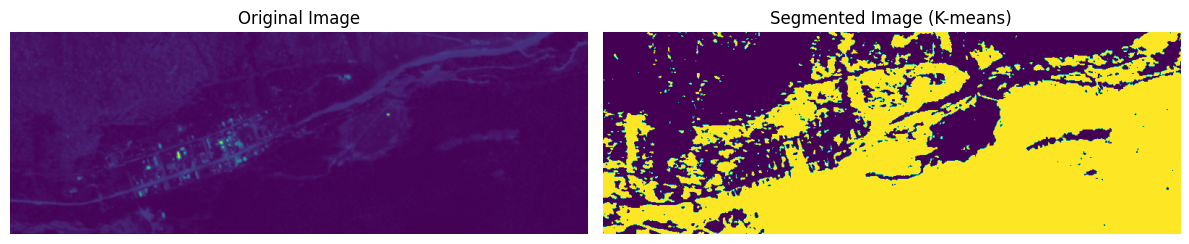

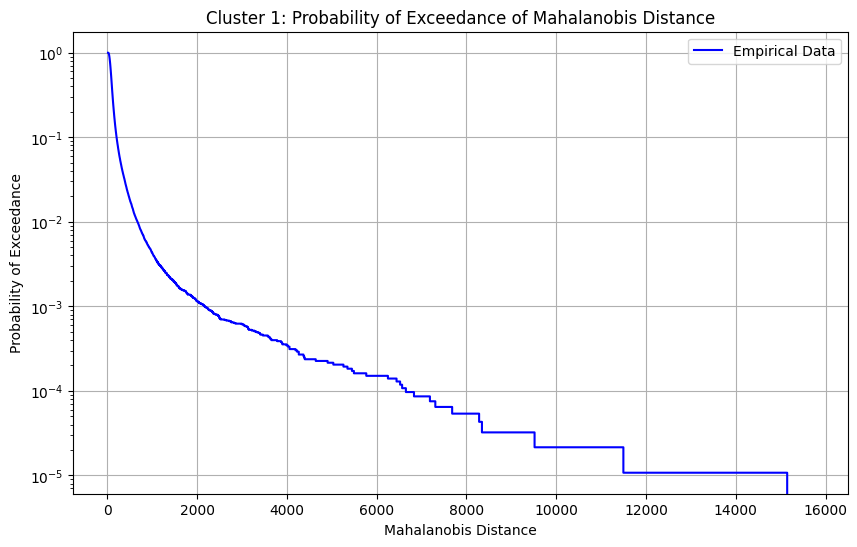

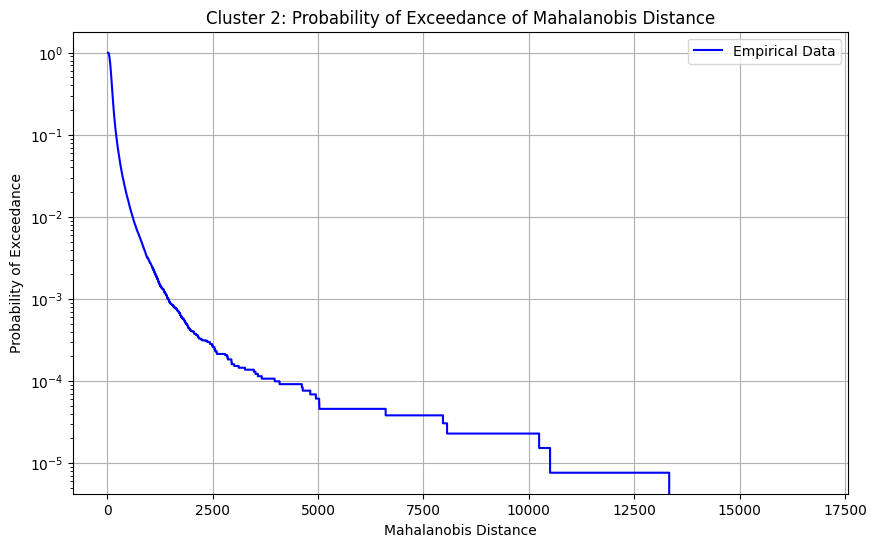

In [6]:
k = 2
clustered_mask = segmention(rit.cube, k)
clusters_db= []

for i in range(k):

  # Clac Mahobinis Distance
  pixels_in_cluster = np.array([rit_sub_m8.cube[j,n,:] for j in range(rit_sub_m8.rows) for n in range(rit_sub_m8.cols) if clustered_mask[j, n] == i])
  cluster_mean = np.array([np.mean(pixels_in_cluster[:,j]) for j in range(rit_sub_m8.bands)])
  cluster_cov = np.cov(pixels_in_cluster, rowvar=False)
  mahobinis_distance = calculate_mahalanobis_distances(pixels_in_cluster, cluster_mean, cluster_cov)

  # Sort the distances
  data_d = np.sort(mahobinis_distance)

  # Calculate the probability of exceedance
  data_exeedance = 1 - np.arange(1, len(data_d) + 1) / len(data_d)

  clusters_db.append({"mean": cluster_mean, "cov": cluster_cov, "d": data_d, "exeedance": data_exeedance})

  # Plot the Probability of Exceedance against Distance
  plt.figure(figsize=(10, 6))
  plt.step(data_d, data_exeedance, linestyle='-', color='b', label='Empirical Data')
  plt.xlabel('Mahalanobis Distance')
  plt.ylabel('Probability of Exceedance')
  plt.title(f'Cluster {i+1}: Probability of Exceedance of Mahalanobis Distance')
  plt.yscale('log')  # Set y-axis to logarithmic scale
  plt.grid(True)
  plt.legend()
  plt.show()


params = [  0.5 100.    5. ]
exeedance_metric = 62179.990823393
params = [  0.525 100.      5.   ]
exeedance_metric = 64082.24311467083
params = [  0.5 105.    5. ]
exeedance_metric = 62205.64525571112
params = [  0.5  100.     5.25]
exeedance_metric = 68706.8293290727
params = [  0.51666667 103.33333333   4.75      ]
exeedance_metric = 55803.1299667665
params = [  0.525 105.      4.5  ]
exeedance_metric = 47488.84767618796
params = [  0.49166667 106.66666667   4.66666667]
exeedance_metric = 50888.161578388725
params = [  0.51111111 102.77777778   4.44444444]
exeedance_metric = 43872.92648824348
params = [  0.51666667 101.66666667   4.16666667]
exeedance_metric = 31092.386016649998
params = [  0.52222222 108.88888889   3.88888889]
exeedance_metric = 14885.440439955195
params = [  0.53333333 113.33333333   3.33333333]
exeedance_metric = 38042.086535424714
params = [  0.55092593 103.7037037    3.7037037 ]
exeedance_metric = 7706.388171341292
params = [  0.58055556 102.22222222   3.222222

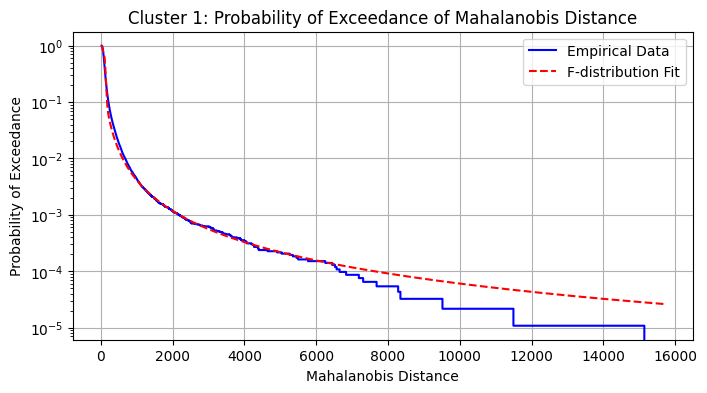

params = [  0.5 100.    5. ]
exeedance_metric = 10773.114899104377
params = [  0.525 100.      5.   ]
exeedance_metric = 12847.255150021096
params = [  0.5 105.    5. ]
exeedance_metric = 10808.692552045835
params = [  0.5  100.     5.25]
exeedance_metric = 18512.464816340256
params = [  0.51666667 103.33333333   4.75      ]
exeedance_metric = 6738.0368054876935
params = [  0.525 105.      4.5  ]
exeedance_metric = 11968.926915567949
params = [  0.48611111 105.55555556   4.83333333]
exeedance_metric = 6431.335526561831
params = [  0.46666667 108.33333333   4.75      ]
exeedance_metric = 7532.551457503085
params = [  0.50185185 100.92592593   4.72222222]
exeedance_metric = 7218.613310596271
params = [  0.50308642 106.54320988   4.53703704]
exeedance_metric = 11879.356569823707
params = [  0.5007716  101.63580247   4.88425926]
exeedance_metric = 7463.817923486323
params = [  0.50231481 104.90740741   4.65277778]
exeedance_metric = 8398.84915444456
params = [  0.50115741 102.4537037    4.

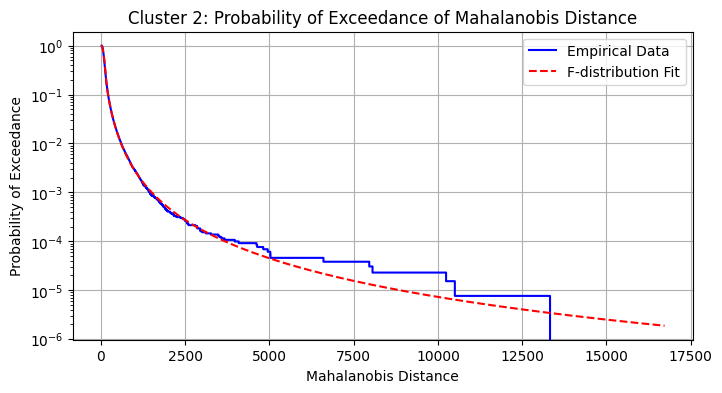

In [7]:
for i in range(k):
  best_params = find_best_mixture(clusters_db[i]["d"], clusters_db[i]["exeedance"], rit_sub_m8.bands, method="optimization")
  clusters_db[i]["best_params"] = best_params
  mixture_d = np.linspace(0, np.max(clusters_db[i]["d"]), 1000000)
  mixture_f = create_mixture_f_cdf(params= best_params, L=rit_sub_m8.bands)
  mixture_exeedance = 1 - mixture_f(mixture_d)

  plt.figure(figsize=(8, 4))
  plt.step(clusters_db[i]["d"], clusters_db[i]["exeedance"], linestyle='-', color='b', label='Empirical Data')
  plt.plot(mixture_d, mixture_exeedance, linestyle='--', color='r', label='F-distribution Fit')
  plt.yscale('log')  # Set y-axis to logarithmic scale
  plt.grid(True)
  plt.title(f'Cluster {i+1}: Probability of Exceedance of Mahalanobis Distance')
  plt.xlabel('Mahalanobis Distance')
  plt.ylabel('Probability of Exceedance')
  plt.legend()
  plt.show()

  w, nu1, nu2 = clusters_db[i]["best_params"]
  clusters_db[i]["mixture_t"] = MixtureMultivarientT(mean=clusters_db[i]["mean"], cov=clusters_db[i]["cov"], w=w, nu1=nu1, nu2=nu2)


In [8]:

new_method_art_rit_path = drive_path + 'new_method_art_rit.npy'
if not (os.path.exists(new_method_art_rit_path) and os.path.isfile(new_method_art_rit_path)) :
  new_art_rit_cube = np.zeros((rit_sub_m8.rows, rit_sub_m8.cols, rit_sub_m8.bands))
  for row in range(new_art_rit_cube.shape[0]):
    for col in range(new_art_rit_cube.shape[1]):
      print(f"genereting pixel {row, col}")
      new_art_rit_cube[row, col, :] = clusters_db[clustered_mask[row, col]]["mixture_t"].rvs()
  np.save(new_method_art_rit_path, new_art_rit_cube)
else:
  new_art_rit_cube = np.load(new_method_art_rit_path)

new_art_rit = HyperSpectralCube(None, new_art_rit_cube)
new_art_rit.calc_cov("global")
cube_dict["Art RIT with New Method"] = new_art_rit


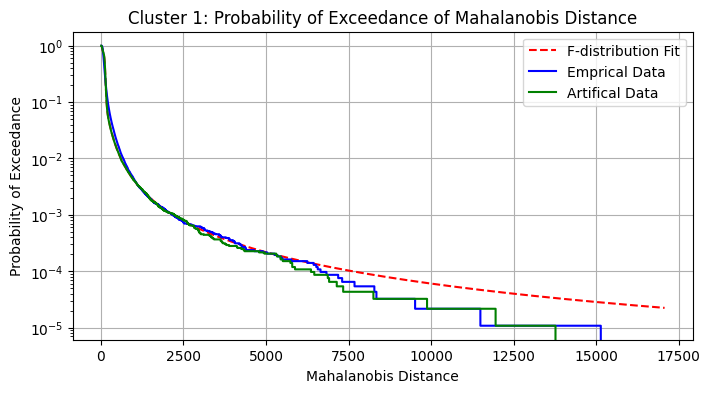

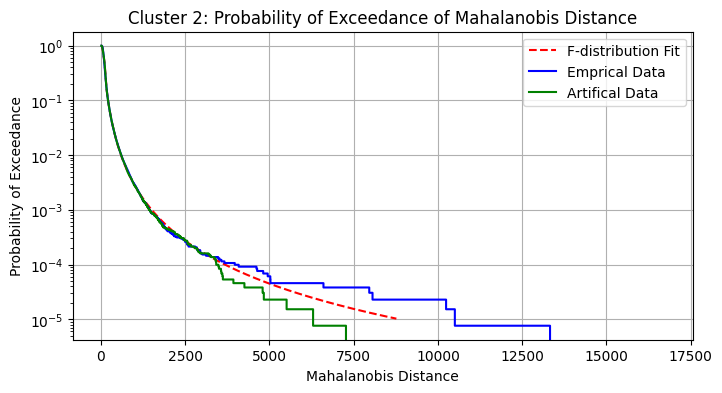

In [9]:

for i in range(k):

  # Clac Mahobinis Distance
  pixels_in_cluster = np.array([new_art_rit.cube[j,n,:] for j in range(new_art_rit.rows) for n in range(new_art_rit.cols) if clustered_mask[j, n] == i])
  cluster_mean = np.array([np.mean(pixels_in_cluster[:,j]) for j in range(new_art_rit.bands)])
  cluster_cov = np.cov(pixels_in_cluster, rowvar=False)
  mahobinis_distance = calculate_mahalanobis_distances(pixels_in_cluster, cluster_mean, cluster_cov)

  # Sort the distances
  art_d = np.sort(mahobinis_distance)

  # Calculate the probability of exceedance
  art_exeedance = 1 - np.arange(1, len(art_d) + 1) / len(art_d)


  mixture_d = np.linspace(0, max(art_d), 1000000)
  mixture_f = create_mixture_f_cdf(params= clusters_db[i]["best_params"], L=rit_sub_m8.bands)
  mixture_exeedance = 1 - mixture_f(mixture_d)

  plt.figure(figsize=(8, 4))
  plt.plot(mixture_d, mixture_exeedance, linestyle='--', color='r', label='F-distribution Fit')
  plt.step(clusters_db[i]["d"], clusters_db[i]["exeedance"], linestyle='-', color='b', label='Emprical Data')
  plt.step(art_d, art_exeedance, linestyle='-', color='g', label='Artifical Data')
  plt.title(f'Cluster {i+1}: Probability of Exceedance of Mahalanobis Distance')
  plt.yscale('log')  # Set y-axis to logarithmic scale
  plt.grid(True)
  plt.legend()
  plt.xlabel('Mahalanobis Distance')
  plt.ylabel('Probability of Exceedance')
  plt.show()

6. Match Filter (MF) Comparison

name_of_estimation_method is None, using default name
name_of_the_dataset is None, using default name
the AUC for Original RIT Sub Local Mean is 0.08001827369658801
[Errno 2] No such file or directory: 'plots/Generic_Generic__17_08_2024__09_13_41.png'
name_of_estimation_method is None, using default name
name_of_the_dataset is None, using default name
the AUC for Art RIT with Prev Method Num 1 is 0.08072177050781251
name_of_estimation_method is None, using default name
name_of_the_dataset is None, using default name
the AUC for Art RIT with Prev Method Num 2 is 0.08398476399075255
name_of_estimation_method is None, using default name
name_of_the_dataset is None, using default name
the AUC for Art RIT with New Method is 0.07969822572544642


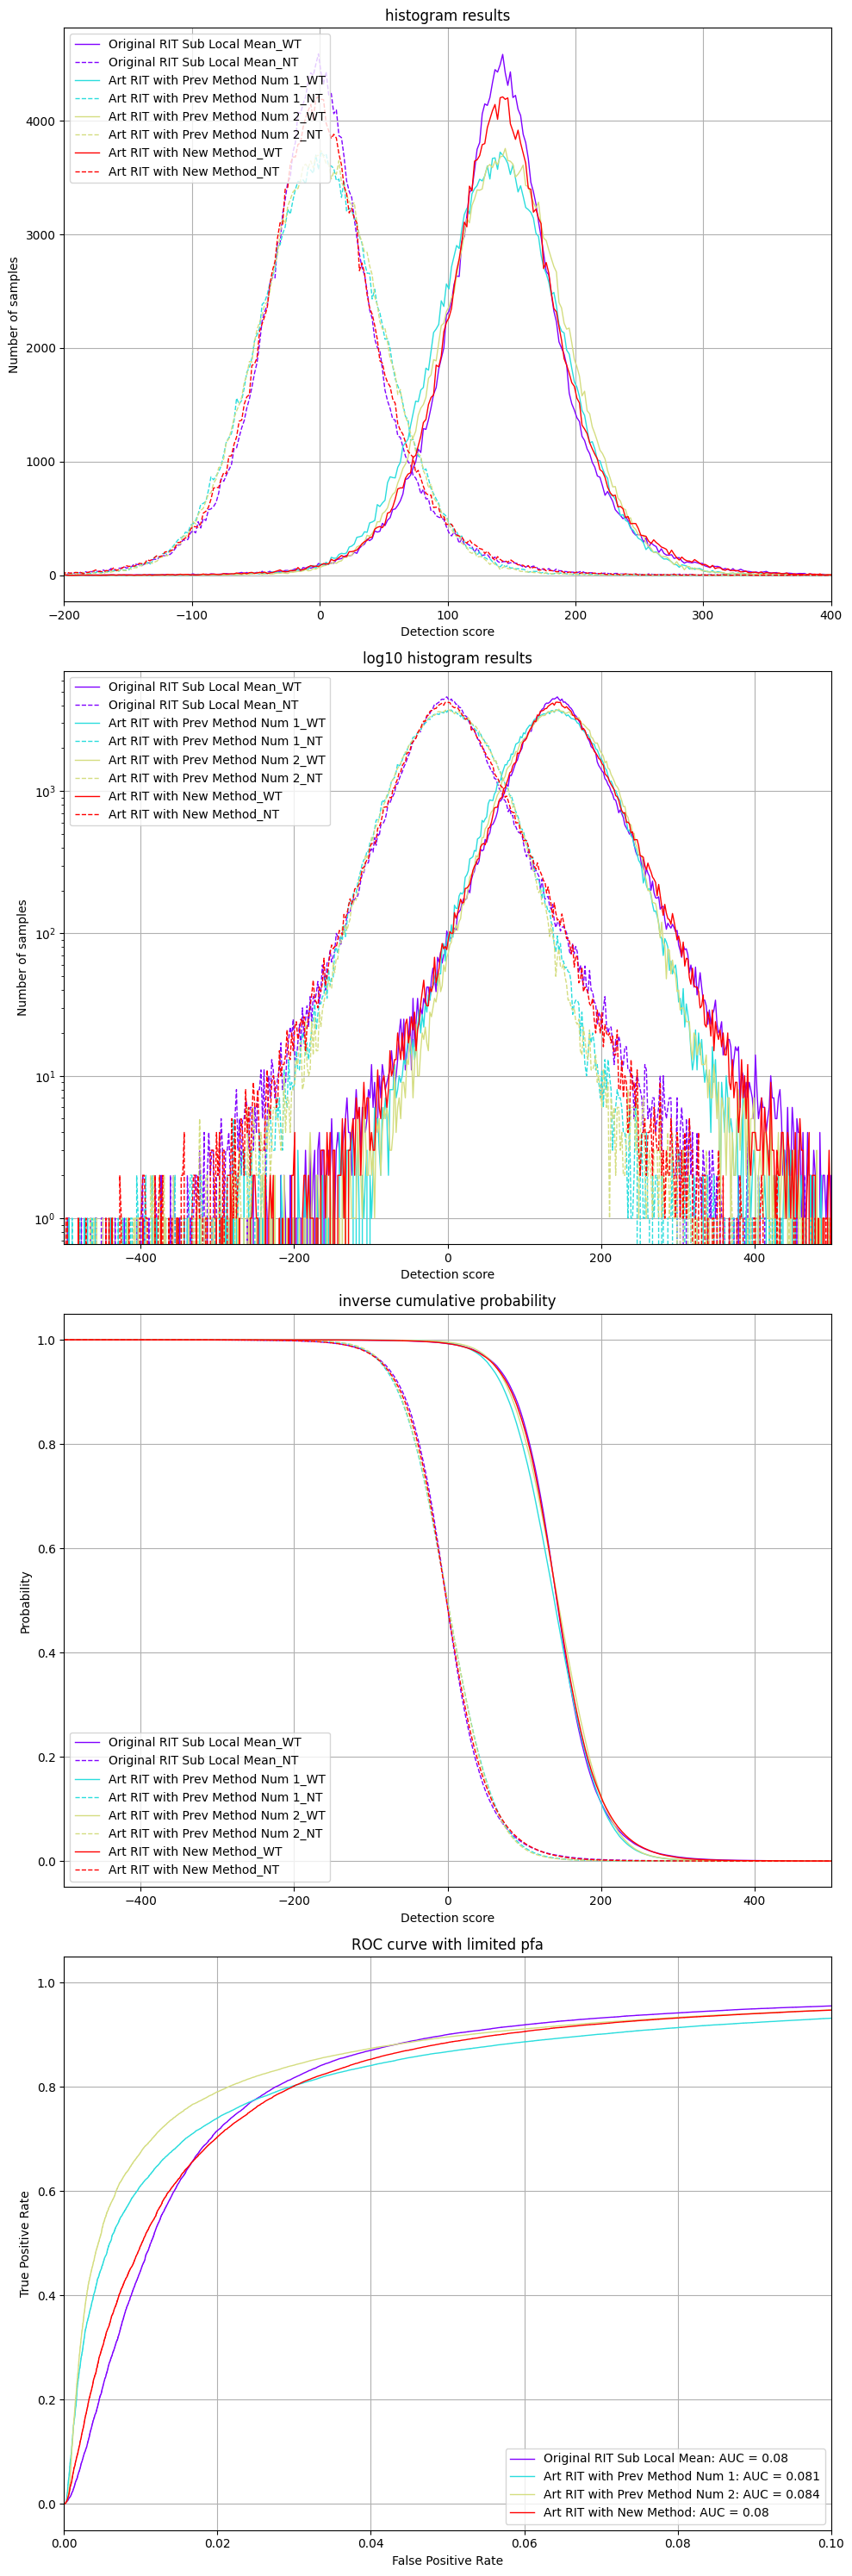

<Figure size 1200x600 with 0 Axes>

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(10, 30))
i = 0
color = plt.cm.rainbow(np.linspace(0, 1, len(cube_dict)))
plt.figure(figsize=(12, 6))
for name, cube in cube_dict.items():


  mf_cov = get_autocorr(cube.cube) # local mean already substracted
  mf_mean = 0

  mf_res = matched_filter(0.05,cube.cube, mf_mean, mf_cov, rit.cube[16,16].reshape(1, 1, -1))
  histogram_wt, histogram_nt, fpr, tpr, thresholds = calc_stats(mf_res[WT], mf_res[NT])

  plot_stats([histogram_wt],
              [histogram_nt],
              [fpr],
              [tpr],
              [thresholds],
              fig,
              ax,
              color[i],
              [name])
  i+=1

plt.show()


Extra: Statistical Comparison Plots - Used For The Report

---



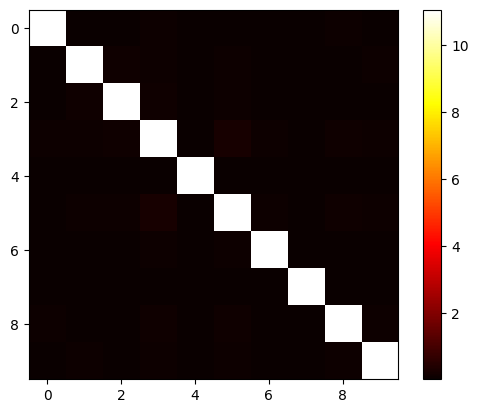

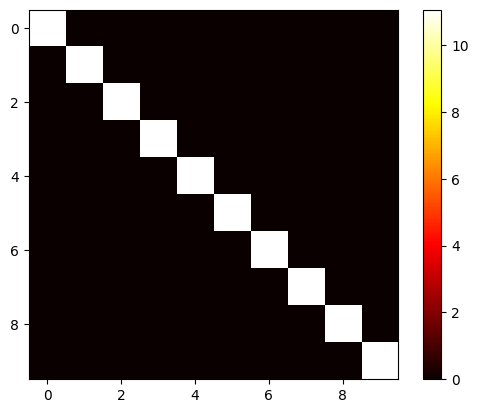

In [13]:
pca_cube_mutual_info_matrix = get_mutual_info_matrix(rit_pca.cube[:,:,0:10])
art_pca_cube_mutual_info_matrix = get_mutual_info_matrix(old_art_rit_pca.cube[:,:,0:10])

plt.imshow(pca_cube_mutual_info_matrix, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(art_pca_cube_mutual_info_matrix, cmap='hot')
plt.colorbar()
plt.show()

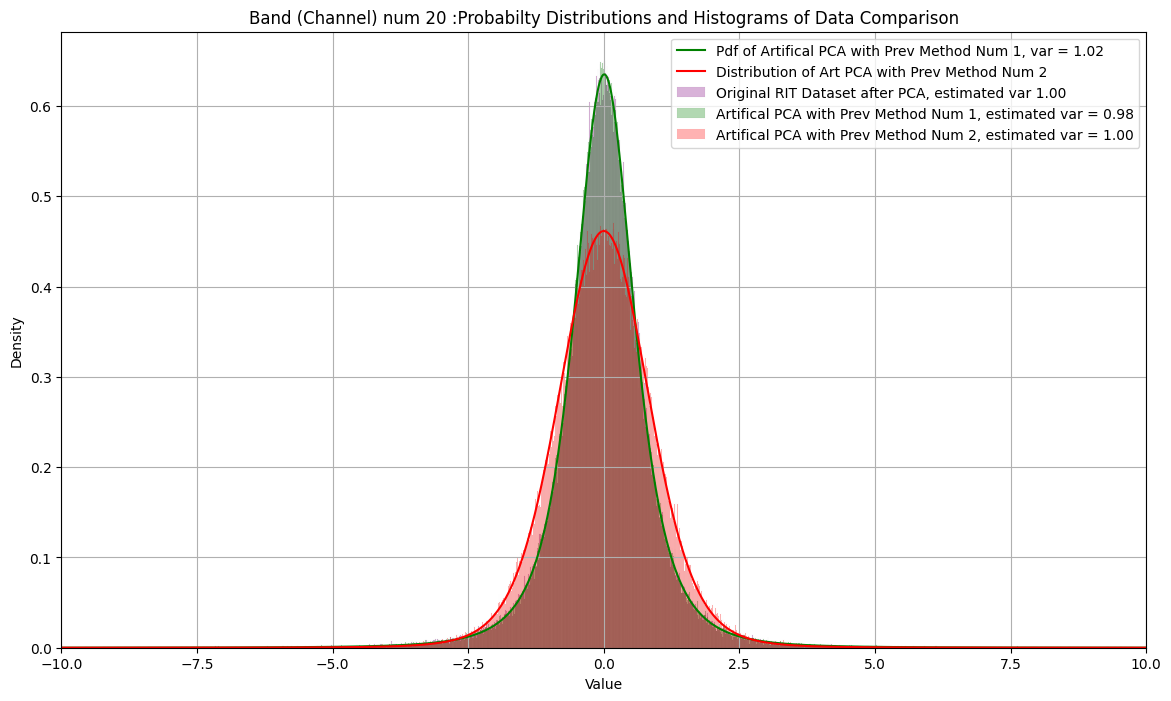

In [14]:
BAND_TO_PLOT = 20
X1 = -50
X2 = +50
NUM_POINTS = 10000

x  = np.linspace(X1, X2, NUM_POINTS)
dx = (X2 - X1)/NUM_POINTS;

rit_pca_flat                  = rit_pca.cube[:,:,BAND_TO_PLOT].flatten()
old_art_rit_pca_flat          = old_art_rit_pca.cube[:,:,BAND_TO_PLOT].flatten()
old_art_rit_pca_sec_pca_flat  = old_art_rit_pca_sec_pca.cube[:,:,BAND_TO_PLOT].flatten()

pdf_old_art_rit_pca =  calc_t_dist(x, old_method_stats_arr[BAND_TO_PLOT][0], old_method_stats_arr[BAND_TO_PLOT][1], old_method_stats_arr[BAND_TO_PLOT][2])

pdfs_to_sum  = [calc_t_dist(x, old_method_stats_arr[band][0],
                old_method_stats_arr[band][1],
                old_method_stats_arr[band][2],
                (old_art_rit_pca.eigenvectors[band][BAND_TO_PLOT] / np.sqrt(old_art_rit_pca.eigenvalues[BAND_TO_PLOT])))
                for band in range(old_art_rit_pca_sec_pca.bands)]

pdf_old_art_rit_pca_sec_pca = sum_of_t_distributions(pdfs_to_sum, dx)
mean = np.sum(x * pdf_old_art_rit_pca_sec_pca) / np.sum(pdf_old_art_rit_pca_sec_pca)


plt.figure(figsize=(14, 8))

sns.histplot(rit_pca_flat, kde=False, stat="density", bins=5000, color='purple', alpha=0.3, label= f"Original RIT Dataset after PCA, estimated var {rit_pca.cov[BAND_TO_PLOT,BAND_TO_PLOT]:.2f}")
sns.histplot(old_art_rit_pca_flat, kde=False, stat="density", bins=5000, color='green', alpha=0.3, label=f"Artifical PCA with Prev Method Num 1, estimated var = {old_art_rit_pca.cov[BAND_TO_PLOT,BAND_TO_PLOT]:.2f}")
sns.histplot(old_art_rit_pca_sec_pca_flat, kde=False, stat="density", bins=5000, color='red', alpha=0.3, label=f"Artifical PCA with Prev Method Num 2, estimated var = {old_art_rit_pca_sec_pca.cov[BAND_TO_PLOT,BAND_TO_PLOT]:.2f}")



plt.plot(x, pdf_old_art_rit_pca, label=f"Pdf of Artifical PCA with Prev Method Num 1, var = {((old_method_stats_arr[BAND_TO_PLOT][0]*old_method_stats_arr[BAND_TO_PLOT][2]**2)/(old_method_stats_arr[BAND_TO_PLOT][0]-2)):.2f}", color='green')
plt.plot(x - mean, pdf_old_art_rit_pca_sec_pca, label=f'Distribution of Art PCA with Prev Method Num 2' ,color='red')

plt.xlim(-10,+10)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Band (Channel) num "+str(BAND_TO_PLOT)+" :Probabilty Distributions and Histograms of Data Comparison")
plt.legend()
plt.grid(True)
plt.show()

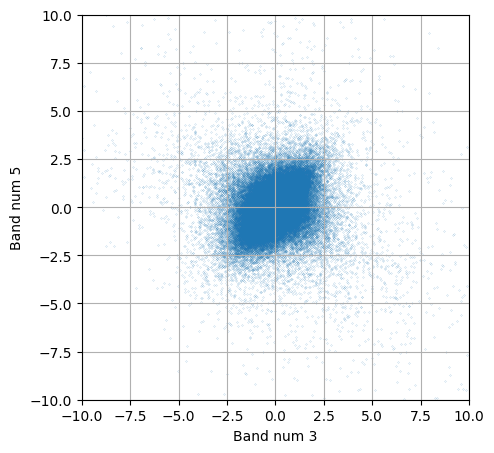

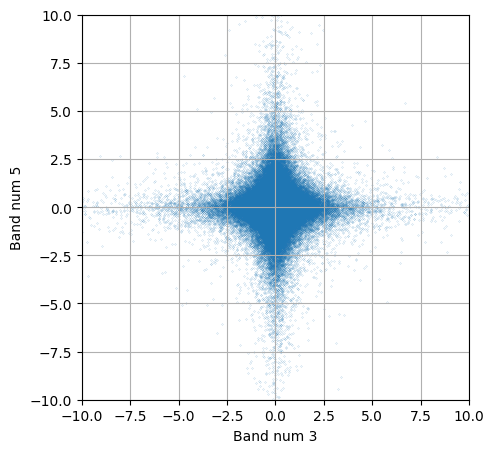

In [15]:
BAND_1 = 3
BAND_2 = 5

plt.figure(figsize=(5, 5))
x = rit_pca.cube[:,:,BAND_1].flatten()
y = rit_pca.cube[:,:,BAND_2].flatten()
plt.scatter(x, y, s=0.01)
#plt.title()
plt.xlabel('Band num '+str(BAND_1))
plt.ylabel('Band num '+str(BAND_2))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid(True)

plt.figure(figsize=(5, 5))
x = old_art_rit_pca.cube[:,:,BAND_1].flatten()
y = old_art_rit_pca.cube[:,:,BAND_2].flatten()
plt.scatter(x, y, s=0.01)
#plt.title()
plt.xlabel('Band num '+str(BAND_1))
plt.ylabel('Band num '+str(BAND_2))
plt.xlim(-10,10)
plt.ylim(-10,10)

plt.grid(True)
plt.show()

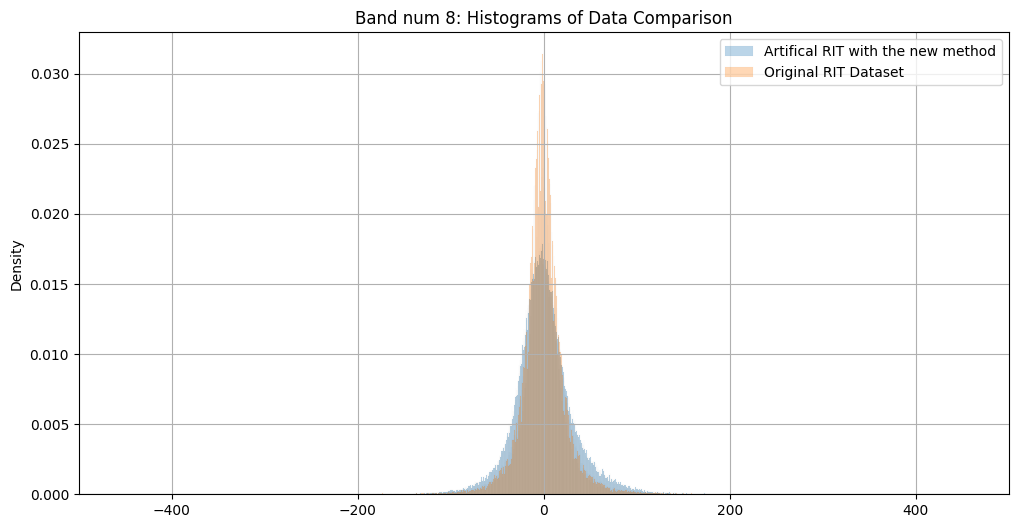

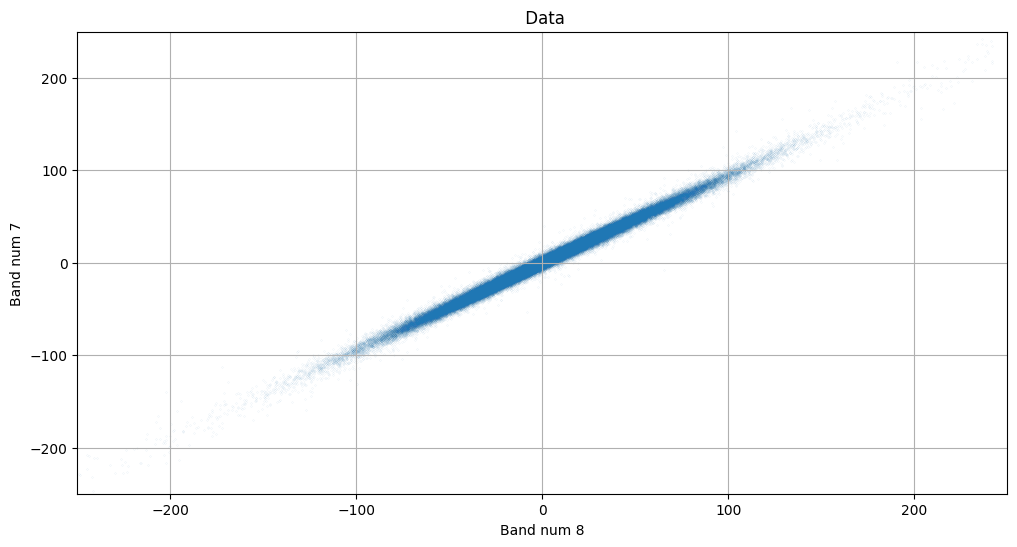

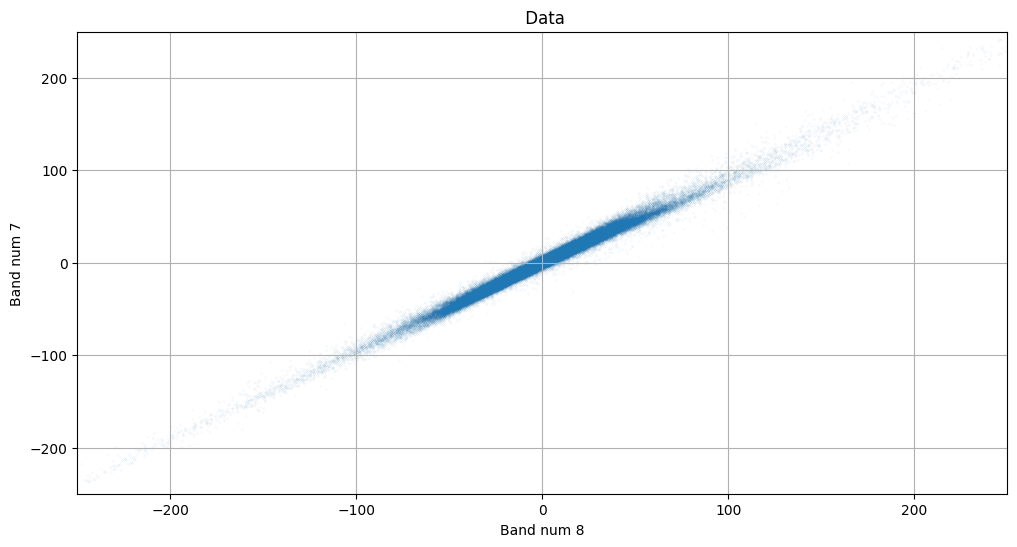

In [16]:

BAND_1 = 8
BAND_2 = 7

plt.figure(figsize=(12, 6))
data = (new_art_rit.cube[:,:,BAND_1]).flatten()
sns.histplot(data, kde=False, stat="density", bins=5000, alpha=0.3, label="Artifical RIT with the new method")
data = (rit_sub_m8.cube[:,:,BAND_1]).flatten()
sns.histplot(data, kde=False, stat="density", bins=5000, alpha=0.3, label="Original RIT Dataset")
plt.xlim(-500, +500)
plt.legend()
plt.grid(True)
plt.title("Band num "+str(BAND_1)+": Histograms of Data Comparison")
plt.show()

#plt.figure(figsize=(12, 6))
#plt.imshow(get_cov8(cube.cube, "global"), cmap='hot')
#plt.title(name + " Cov Matrix")
#plt.colorbar()
#plt.show()

plt.figure(figsize=(12, 6))
x = (new_art_rit.cube[:,:,BAND_1]).flatten()
y = (new_art_rit.cube[:,:,BAND_2]).flatten()
plt.scatter(x, y, s=0.001)
plt.title(" Data")
plt.xlabel('Band num '+str(BAND_1))
plt.ylabel('Band num '+str(BAND_2))
plt.xlim(-250, +250)
plt.ylim(-250, +250)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
x = (rit_sub_m8.cube[:,:,BAND_1]).flatten()
y = (rit_sub_m8.cube[:,:,BAND_2]).flatten()
plt.scatter(x, y, s=0.001)
plt.title(" Data")
plt.xlabel('Band num '+str(BAND_1))
plt.ylabel('Band num '+str(BAND_2))
plt.xlim(-250, +250)
plt.ylim(-250, +250)
plt.grid(True)
plt.show()